In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

def weighted_knn(X_train, y_train, X_query, k=3):
    """
    Weighted K-Nearest Neighbor (W-KNN) implementation.

    Args:
    - X_train: Training feature set
    - y_train: Training labels
    - X_query: Query point (single data point for classification)
    - k: Number of nearest neighbors to consider

    Returns:
    - predicted_label: Predicted label for the query point
    """
    # Calculate Euclidean distances between query point and all training points
    distances = np.linalg.norm(X_train - X_query, axis=1)
    
    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the labels of the k nearest neighbors
    nearest_labels = y_train[nearest_indices]
    
    # Calculate the weights as the inverse of distances
    weights = 1 / (distances[nearest_indices] + 1e-5)  # Add small constant to avoid division by zero
    
    # Weighted majority voting
    unique_labels = np.unique(nearest_labels)
    weighted_votes = np.zeros(len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        # Sum the weights of the neighbors with the same label
        weighted_votes[i] = np.sum(weights[nearest_labels == label])
    
    # Predict the label with the highest weight
    predicted_label = unique_labels[np.argmax(weighted_votes)]
    
    return predicted_label

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Evaluate the W-KNN classifier
predictions = []
for i in range(len(X_test)):
    query_point = X_test.iloc[i].values
    predicted_label = weighted_knn(X_train.values, y_train.values, query_point, k=150)
    predictions.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with Weighted K-Nearest Neighbor (W-KNN): {accuracy * 100:.2f}%")


Accuracy with Weighted K-Nearest Neighbor (W-KNN): 88.89%


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Implement Condensed Nearest Neighbor (CNN) manually
def condensed_nearest_neighbor(X, y):
    # Start with an empty condensed set
    X_cnn, y_cnn = [], []
    
    # Iterate through each sample
    for i in range(len(X)):
        if len(X_cnn) == 0:  # Add the first sample to the condensed set
            X_cnn.append(X[i])
            y_cnn.append(y[i])
        else:
            # Check if the sample is misclassified by the current nearest neighbors
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_cnn, y_cnn)
            if knn.predict([X[i]]) != y[i]:  # Misclassified, add to condensed set
                X_cnn.append(X[i])
                y_cnn.append(y[i])
    
    return pd.DataFrame(X_cnn), pd.Series(y_cnn)

# Apply CNN to reduce the dataset
X_res, y_res = condensed_nearest_neighbor(X_scaled, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train a K-Nearest Neighbors classifier on the condensed dataset
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.68


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def condensed_nearest_neighbor(X_train, y_train):
    """
    Condensed Nearest Neighbor (CNN) implementation.
    """
    X_train = X_train.values
    y_train = y_train.values
    X_condensed = [X_train[0]]
    y_condensed = [y_train[0]]

    changed = True
    while changed:
        changed = False
        for i, x_i in enumerate(X_train):
            distances = np.linalg.norm(np.array(X_condensed) - x_i, axis=1)
            nearest_index = np.argmin(distances)
            predicted_label = y_condensed[nearest_index]

            if predicted_label != y_train[i]:
                X_condensed.append(x_i)
                y_condensed.append(y_train[i])
                changed = True

    return np.array(X_condensed), np.array(y_condensed)

def reduced_nearest_neighbor(X_condensed, y_condensed):
    """
    Reduced Nearest Neighbor (RNN) implementation.
    """
    X_condensed = list(X_condensed)
    y_condensed = list(y_condensed)
    
    for i in range(len(X_condensed) - 1, -1, -1):  # Iterate in reverse to avoid indexing issues
        # Temporarily remove the point
        test_point = X_condensed.pop(i)
        test_label = y_condensed.pop(i)
        
        # Train a k-NN classifier with the remaining points
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_condensed, y_condensed)
        
        # Check if the point can be removed
        predicted_label = knn.predict([test_point])[0]
        if predicted_label != test_label:
            # If misclassified, add it back
            X_condensed.insert(i, test_point)
            y_condensed.insert(i, test_label)

    return np.array(X_condensed), np.array(y_condensed)

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 1: Obtain the condensed set using CNN
X_condensed, y_condensed = condensed_nearest_neighbor(X_train, y_train)

# Step 2: Apply RNN to refine the condensed set
X_reduced, y_reduced = reduced_nearest_neighbor(X_condensed, y_condensed)

# Evaluate the reduced dataset
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_reduced, y_reduced)
y_pred = knn.predict(X_test)

# Print results
original_size = len(X_train)
condensed_size = len(X_condensed)
reduced_size = len(X_reduced)
accuracy = accuracy_score(y_test, y_pred)

print(f"Original training set size: {original_size}")
print(f"Condensed training set size: {condensed_size}")
print(f"Reduced training set size: {reduced_size}")
print(f"Reduction in size after RNN: {100 * (1 - reduced_size / original_size):.2f}%")
print(f"Accuracy with reduced dataset: {accuracy * 100:.2f}%")


Original training set size: 398
Condensed training set size: 69
Reduced training set size: 48
Reduction in size after RNN: 87.94%
Accuracy with reduced dataset: 82.46%


C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def edited_nearest_neighbor(X_train, y_train, k=3):
    """
    Edited Nearest Neighbor (ENN) implementation.
    
    Args:
    - X_train: Training features
    - y_train: Training labels
    - k: Number of neighbors to consider
    
    Returns:
    - X_edited: Edited feature set
    - y_edited: Edited label set
    """
    X_train = X_train.values  # Convert to numpy for efficient computation
    y_train = y_train.values

    changed = True
    while changed:
        changed = False
        for i in range(len(X_train)):
            # Get the k-nearest neighbors of the current point
            distances = np.linalg.norm(X_train - X_train[i], axis=1)
            nearest_indices = np.argsort(distances)[1:k+1]  # Exclude the point itself

            # Get the labels of the k-nearest neighbors
            nearest_labels = y_train[nearest_indices]

            # If the label of the point does not match the majority of its neighbors, remove it
            majority_label = Counter(nearest_labels).most_common(1)[0][0]
            if y_train[i] != majority_label:
                # Remove point from training set
                X_train = np.delete(X_train, i, axis=0)
                y_train = np.delete(y_train, i)
                changed = True
                break  # Re-evaluate from the start due to dataset modification

    return X_train, y_train

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply Edited Nearest Neighbor (ENN)
X_edited, y_edited = edited_nearest_neighbor(X_train, y_train, k=100)

# Evaluate the edited dataset
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_edited, y_edited)
y_pred = knn.predict(X_test)

# Print results
original_size = len(X_train)
edited_size = len(X_edited)
accuracy = accuracy_score(y_test, y_pred)

print(f"Original training set size: {original_size}")
print(f"Edited training set size: {edited_size}")
print(f"Reduction in size: {100 * (1 - edited_size / original_size):.2f}%")
print(f"Accuracy with edited dataset: {accuracy * 100:.2f}%")


Original training set size: 398
Edited training set size: 333
Reduction in size: 16.33%
Accuracy with edited dataset: 84.80%


C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def selective_nearest_neighbor(X_train, y_train, X_query, k=3, threshold=0.5):
    """
    Selective Nearest Neighbor (SNN) implementation.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    - X_query: Query point (single data point for classification)
    - k: Number of nearest neighbors to consider
    - threshold: Similarity threshold to select relevant neighbors
    
    Returns:
    - predicted_label: Predicted label for the query point
    """
    # Calculate Euclidean distances between query point and all training points
    distances = np.linalg.norm(X_train - X_query, axis=1)
    
    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the labels of the k nearest neighbors
    nearest_labels = y_train[nearest_indices]
    
    # Select relevant neighbors based on a similarity threshold (distance-based)
    relevant_neighbors = []
    for i in range(1, len(nearest_labels)):
        if distances[nearest_indices[i]] - distances[nearest_indices[i - 1]] < threshold:
            relevant_neighbors.append(nearest_labels[i])

    if len(relevant_neighbors) > 0:
        # Majority voting among relevant neighbors
        predicted_label = np.bincount(relevant_neighbors).argmax()
    else:
        # If no relevant neighbors, default to majority voting of all neighbors
        predicted_label = np.bincount(nearest_labels).argmax()
    
    return predicted_label

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Evaluate the SNN classifier
predictions = []
for i in range(len(X_test)):
    query_point = X_test.iloc[i].values
    predicted_label = selective_nearest_neighbor(X_train.values, y_train.values, query_point, k=100, threshold=0.5)
    predictions.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with Selective Nearest Neighbor (SNN): {accuracy * 100:.2f}%")


Accuracy with Selective Nearest Neighbor (SNN): 88.30%


<Figure size 800x800 with 0 Axes>

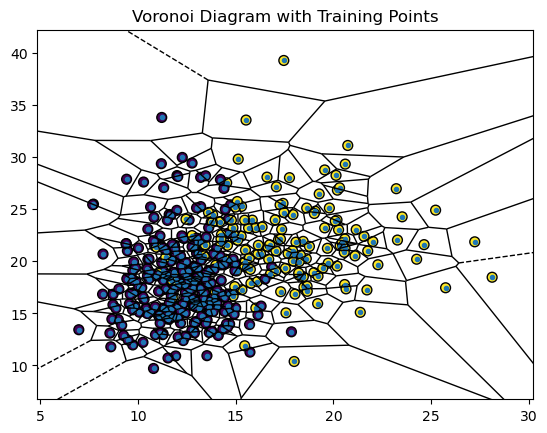

Accuracy with Voronoi Boundary Nearest Neighbor (VBNN): 88.89%


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def voronoi_boundary_nearest_neighbor(X_train, y_train, X_query, k=3):
    """
    Voronoi Boundary Nearest Neighbor (VBNN) implementation.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    - X_query: Query point (single data point for classification)
    - k: Number of nearest neighbors to consider
    
    Returns:
    - predicted_label: Predicted label for the query point
    """
    # Calculate Euclidean distances between query point and all training points
    distances = np.linalg.norm(X_train - X_query, axis=1)
    
    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the labels of the k nearest neighbors
    nearest_labels = y_train[nearest_indices]
    
    # Majority voting among k nearest neighbors
    predicted_label = np.bincount(nearest_labels).argmax()
    
    return predicted_label

def plot_voronoi(X_train, y_train):
    """
    Plot Voronoi diagram for the training data points.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    """
    # Generate Voronoi diagram
    vor = Voronoi(X_train)
    
    # Plot the Voronoi diagram
    plt.figure(figsize=(8, 8))
    voronoi_plot_2d(vor, show_vertices=False)
    
    # Scatter plot of the training data points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=50)
    plt.title("Voronoi Diagram with Training Points")
    plt.show()

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Breast_Cancer.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# If the dataset is multi-dimensional, reduce to two dimensions for visualization purposes (optional)
# For example, we'll use the first two features for demonstration.
X_2d = X.iloc[:, :2]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.3, random_state=42, stratify=y)

# Plot Voronoi diagram for the training set
plot_voronoi(X_train.values, y_train.values)

# Evaluate the VBNN classifier
predictions = []
for i in range(len(X_test)):
    query_point = X_test.iloc[i].values
    predicted_label = voronoi_boundary_nearest_neighbor(X_train.values, y_train.values, query_point, k=3)
    predictions.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with Voronoi Boundary Nearest Neighbor (VBNN): {accuracy * 100:.2f}%")
